# Joint probability experiment

In [1]:
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis

Skipping install of 'ptdalgorithms' from a local remote, the SHA1 (1.0.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
# remove.packages("ptdalgorithms")

In [4]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [5]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [6]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [7]:
Rcpp::sourceCpp("./cpp/coalescent.cpp")

In [8]:
source("plot_functions.R")

In [9]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(family="Arial"))

In [10]:
# p <- ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species)) + despine

# ggplotly(width=600, height=400)

In [11]:
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(size=17)) 

options(repr.plot.width=10, repr.plot.height=7)

# ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species), size=5, alpha=0.5) + scale_color_brewer(palette="Set1") + despine

## Section from Tobias paper that was taken out

We note that, although computationally infeasible in most situations, the joint distribution function of multivariate discrete phase-type distributions can also be described by such a recursive algorithm (and time-inhomogeneous multivariate discrete phase-type distributions as seen later). Instead of defining the probability of the system visiting a vertex at time $t$, we instead keep track of both the visited vertex and the accumulated reward at time $t$. Consider an $\ell+1$-dimensional table for an $\ell$-dimensional multivariate discrete phase-type distribution. The first dimension has $|V|$ entries, one for each vertex. The other dimensions has entries corresponding to the natural numbers from $0$ to $k$ where $k$ is sufficiently large, such that for a given distribution function of specified accumulated rewards $\vec{s}$, $F_{\vec{s}}$, then $k$ is larger or equal to any entry in $\vec{s}$. At a time $t$ an entry in the table corresponds to the probability of the system being in a specific state, and having accumulated a specific vector of integer rewards corresponding to the other dimensions. If we have accumulated more than any of the rewards $\vec{s}$, we assign probability zero to the entry in the table before the next time step. Assuming we have removed the vertices with zero rewards in all dimensions (e.g. using the reward transformation algorithm), then all time steps will increase at least one entry in the reward accumulation, and after a finite number of steps all entries will either be zero, or for the absorbing vertices the total probability of the system having reached an absorbing state with less than or equal to the rewards $\vec{s}$, which is the definition of the cumulative distribution function for the multivariate discrete phase-type distribution.

## Generate standard coalescent state space

If you want to generate the state space:

In [12]:
standard_coalescent <- function(n) {
    
    # n <- 4
      
    state_vector_length <- n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
          
      index <- index + 1
    }
    return(graph)
}
# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

In [16]:
make_discrete <- function(mutation_graph, mutation_rate) {
    # Takes a graph for a continuous distribution and turns
    # it into a descrete one (inplace). Returns a matrix of
    # rewards for computing marginal moments

    # current nr of states in graph
    vlength <- vertices_length(mutation_graph)

    # number of fields in state vector (assumes all are the same length)
    state_vector_length <- length(vertex_at(mutation_graph, 1)$state)

    # list state vector fields to reward at each auxiliary node
    rewarded_state_vector_indexes <- vector(mode = "list", length = state_vector_length)

    # loop all but starting node
    for (i in 2:vlength) {
        vertex <- vertex_at(mutation_graph,i)
        if (vertex$rate > 0) { # not absorbing
            for (j in 1:length(vertex$state)) {
                val <- vertex$state[j]
                if (val > 0) { # only ones we may reward
                    # add auxilliary node
                    mutation_vertex <- create_vertex(mutation_graph, rep(0, state_vector_length))
                    add_edge(mutation_vertex, vertex, 1)
                    add_edge(vertex, mutation_vertex, mutation_rate*val)

                    rewarded_state_vector_indexes[[mutation_vertex$index]] <- c(rewarded_state_vector_indexes[[j]], j)
                }
            }
        }
    }
    # normalize graph
    weights_were_multiplied_with <- normalize_graph(mutation_graph)

    # build reward matrix
    rewards <- matrix(nrow=vertices_length(mutation_graph),ncol=state_vector_length, 0)
    for (state in seq_along(rewarded_state_vector_indexes)) {
        for (i in rewarded_state_vector_indexes[[state]]) {
            rewards[state, i] <- 1
        }
    }
    rewards = t(rewards)
    return(rewards)
}

# self-transition rate:
mutation_rate <- 1e-8

# clone graph to get one to modify:
mutation_graph <- clone_graph(graph)

# add auxilliary states, normalize and return reward matrix:
rewards <- make_discrete(mutation_graph, mutation_rate)

# for plotting the new graph
gam <- graph_as_matrix(mutation_graph)

---

In [17]:
ndigits <- function(x){
  y <- floor(abs(x))
  if(y != 0){
    floor(log10(y)) + 1
  } else {
    1
  }
}
rev_number=function(n){
    m=as.integer(rev(strsplit(as.character(n),"")))
    if (m==rev(m)) print("reversed number")
}
forth <- function(vec, base) {
    # return( as.integer( c(vec %*%  (base ^ rev(seq_along(vec)) / base)) ) )
    return( as.integer( c(vec %*%  (base ^ (seq_along(vec)) / base)) ) )
}
back <- function(x, base, state_length) {
    x <- as.integer(rev(paste(x, collapse='')))
    vec <- c()
    for (i in 1:ndigits(x)) {
        if (x > 0) {
            vec <- c(x %% (base), vec)
            x <- x %/% (base)
        }
    }
    vec <- as.integer(vec)
    return( c(rep(0, state_length-length(vec)), vec) )
}
# base <- 1000
# vec <- c(0, 2, 3)
# state_length <- length(vec)
# print(vec)
# f <- forth(vec, base)
# print(f)
# b <- back(f, 1000, state_length)
# print(b)
# b <- c(rep(0, length(vec)-length(b)), b)
# print(b)

In [18]:
sample_size <- 5
graph <- standard_coalescent(sample_size)
rewards <- make_discrete(graph, 1e-8)
# rewards <- t(states(graph))
rewards

0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
base <- 10
multi_rewards <- apply(rewards, 2, forth, base=base)
multi_rewards

[1]    0    0    0    0    0    0    0    0    1    1   10    1   10    1  100
[16]   10  100    1 1000

In [20]:
g <- reward_transform(graph, multi_rewards)
df <- data.frame(t=seq(0, base^(sample_size-1), 1))
df['prob'] <- sapply(df$t, function (t) dph(t, g))
head(df)

,t,prob
,<dbl>,<dbl>
1,0,2.107163e-08
2,1,8.337103e-09
3,2,3.595845e-09
4,3,1.805817e-09
5,4,1.105361e-09
6,5,8.095276e-10


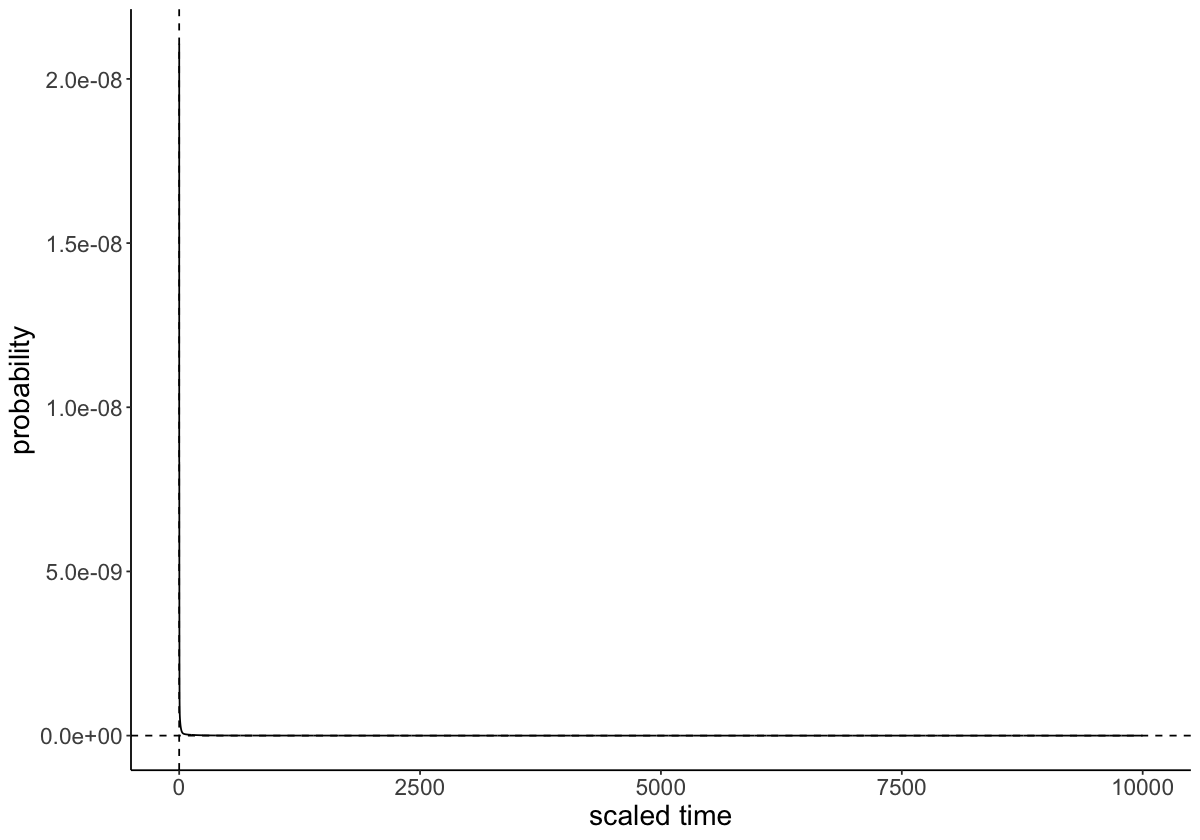

In [21]:
df %>% ggplot(aes(x=t, y=prob)) + 
    geom_line(color='black') + 
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_vline(xintercept = 0, linetype = "dashed") +
    labs(x='scaled time', y='probability') + 
    despine + scale_color_viridis(discrete = TRUE)

In [22]:
rewards

0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
x <- lapply(df$t, back, base=base, state_length=nrow(rewards))
x <- lapply(x, rev)
m <- do.call(rbind, x)
multi_df <- data.frame(m)
multi_df[,] <- lapply(multi_df[,], as.factor)
multi_df['prob'] = df$prob
head(multi_df)

,X1,X2,X3,X4,X5,X6,prob
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
1,0,0,0,0,0,0,2.107163e-08
2,1,0,0,0,0,0,8.337103e-09
3,2,0,0,0,0,0,3.595845e-09
4,3,0,0,0,0,0,1.805817e-09
5,4,0,0,0,0,0,1.105361e-09
6,5,0,0,0,0,0,8.095276e-10


In [24]:
tail(multi_df)

,X1,X2,X3,X4,X5,X6,prob
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
9996,5,9,9,9,0,0,2.281366e-16
9997,6,9,9,9,0,0,2.279086e-16
9998,7,9,9,9,0,0,2.276808e-16
9999,8,9,9,9,0,0,2.274532e-16
10000,9,9,9,9,0,0,2.272259e-16
10001,0,0,0,0,1,0,2.269988e-16


**Sanity check:** the joint probability of any non-zero number of tripletons and any non-zero number fourtons should be zero:

In [25]:
# plot_df <- multi_df %>% group_by(X3, X4) %>% summarise(joint_prob = sum(prob))# %>% filter(X3 > 0 & X4 > 0)
# head(plot_df)
plot_df <- multi_df %>% group_by(X3, X4) %>% summarise(joint_prob = sum(prob))
head(plot_df)

`summarise()` has grouped output by 'X3'. You can override using the `.groups` argument.


X3,X4,joint_prob
<fct>,<fct>,<dbl>
0,0,4.686149e-08
0,1,1.753217e-10
0,2,6.442648e-11
0,3,2.370116e-11
0,4,8.719167e-12
0,5,3.207601e-12


In [26]:
tail(plot_df)

X3,X4,joint_prob
<fct>,<fct>,<dbl>
9,4,3.544947e-12
9,5,1.304113e-12
9,6,4.797560e-13
9,7,1.764923e-13
9,8,6.492785e-14
9,9,2.388561e-14


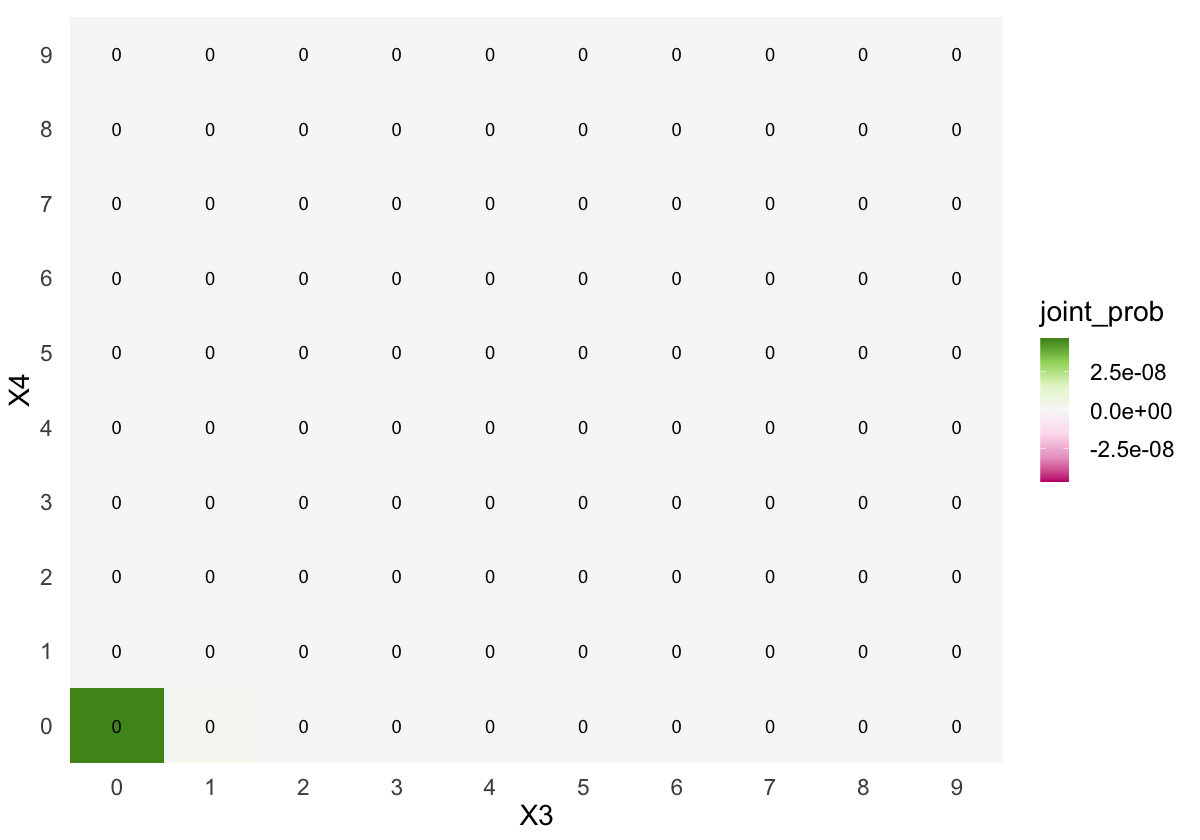

In [27]:
ggplot(plot_df, aes(x=X3, y=X4)) +
    geom_tile(aes(fill = joint_prob)) + 
    geom_text(aes(label = round(joint_prob, 2))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(plot_df$joint_prob)) * c(-1, 1)
                    ) +
theme_minimal() +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))

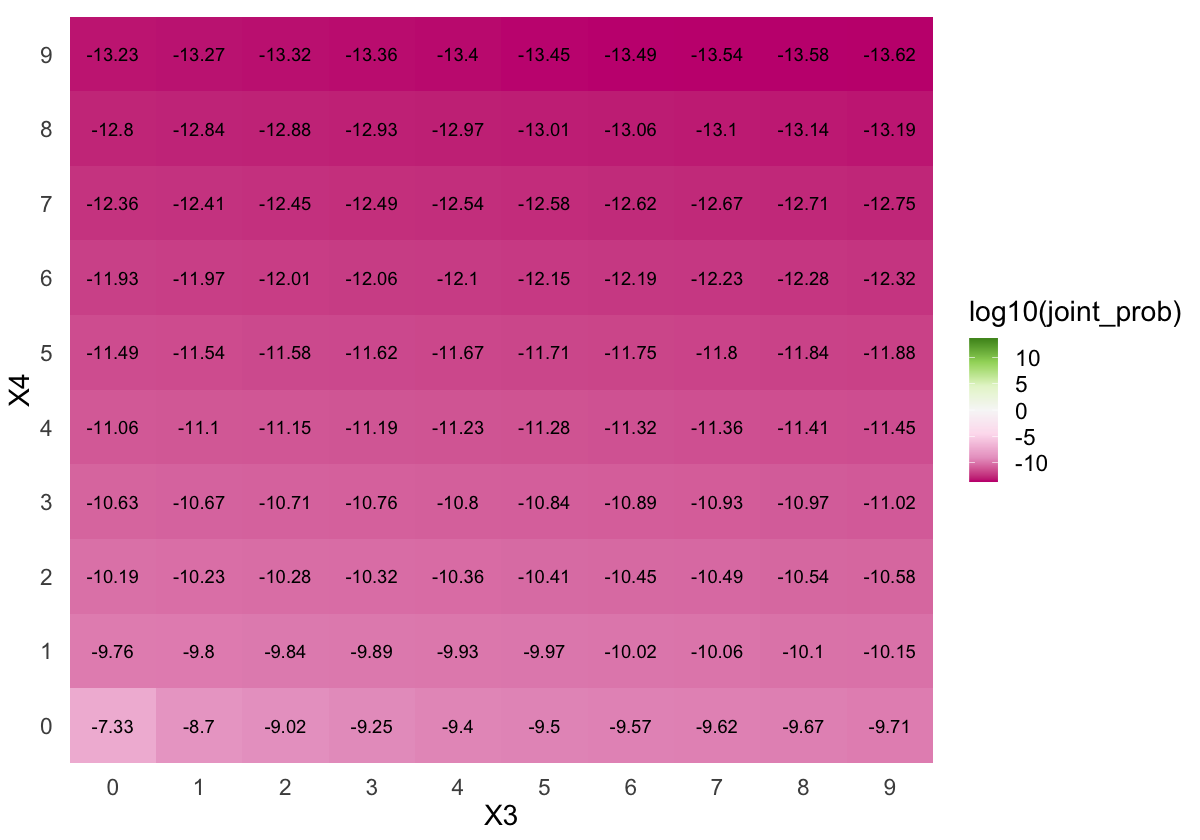

In [28]:
ggplot(plot_df, aes(x=X3, y=X4)) +
    geom_tile(aes(fill = log10(joint_prob))) + 
    geom_text(aes(label = round(log10(joint_prob), 2))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(log10(plot_df$joint_prob))) * c(-1, 1)
                    ) +
theme_minimal() +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))


In [232]:
x <- lapply(df$t, back, base=10, state_length=nrow(rewards))
x <- lapply(x, rev)
scalars <- c(1:sample_size, 0)
mask <- lapply(x, function(v) sum(v * scalars)) == sample_size
m <- do.call(rbind, x[mask])
m

4,0,0,0,0
2,1,0,0,0
0,2,0,0,0


In [ ]:
df[, df$t]

In [228]:
range <- seq(1, 100, 1)
x <- lapply(range, back, base=10, state_length=nrow(rewards))
x <- lapply(x, rev)
scalars <- c(1:sample_size, 0)
mask <- lapply(x, function(v) sum(v * scalars)) == sample_size
m <- do.call(rbind, x[mask])
m

4,0,0,0,0
2,1,0,0,0
0,2,0,0,0


In [230]:
valid_times <- range[mask]
df <- data.frame(t=valid_times)
df['prob'] <- sapply(valid_times, function (t) dph(t, g))
head(df)

,t,prob
,<dbl>,<dbl>
1,4,1.100381e-09
2,12,3.604568e-10
3,20,1.899179e-10


In [ ]:
t <- seq(from = 0, to = 5, by = 0.01)
fun <- function(t) {
    x <- stop_probability(graph, t)
    return(x[2:(length(x)-1)])
}
df <- as.data.frame(t(sapply(t, fun))) 
df['time'] <- t
head(df)

In [72]:
df <- data.frame(t=seq(1, 6, 0.001))
for (n in seq(2, 20))
{
    graph <- standard_coalescent(n)
    df[[n]] <- sapply(df$t, function (t) dph(t, graph))
}

Warning message:
“‘length(width)’ forskellig mellem ny og forrige
	 ==> NOT changing ‘width’”


ERROR: Error in as.character(x): cannot coerce type 'externalptr' to vector of type 'character'


---